In [1]:
library(iml)
library(mlr)
library(data.table)
library(mlrMBO)
library(BBmisc)
library(customtrees)
library(Rfast)
library(ggplot2)
library(gridExtra)
library(partykit)
library(ggparty)

theme_set(theme_bw())

setwd("/home/julia/Documents/repos/paper_2020_xautoml/")

source("R/pdp_helpers.R") # helper functions to plot a partial dependence plot
source("R/tree_splitting.R") # helper functions to perform the tree splitting 
source("R/mlp_helper.r")

Loading required package: ParamHelpers

'mlr' is in maintenance mode since July 2019. Future development
efforts will go into its successor 'mlr3' (<https://mlr3.mlr-org.com>).

Loading required package: smoof

Loading required package: checkmate


Attaching package: ‘BBmisc’


The following object is masked from ‘package:base’:

    isFALSE


Loading required package: Rcpp

Loading required package: RcppZiggurat


Attaching package: ‘Rfast’


The following object is masked from ‘package:data.table’:

    transpose


Loading required package: grid


Attaching package: ‘grid’


The following object is masked from ‘package:BBmisc’:

    explode


Loading required package: libcoin

Loading required package: mvtnorm


Attaching package: ‘mvtnorm’


The following objects are masked from ‘package:Rfast’:

    dmvnorm, dmvt, rmvnorm, rmvt




# Synthetic Functions

In [61]:
id = "StyblinskiTang"
dimension = 5
lambda = 1

path = file.path("data/runs/synthetic", id, paste0(dimension, "D"))

# Get the objective
obj = readRDS(file.path(path, "objective.rds"))
ps = readRDS(file.path(path, "ps.rds"))

ps_ids = getParamIds(ps, repeated = TRUE, with.nr = TRUE)

# Get the run we are interested in 
run = readRDS(file.path(path, paste0("mlrmbo_run_lambda_", lambda, ".rds")))
model = run$models[[length(run$models)]]
best_candidate = as.data.frame(run$opt.path)[run$best.ind, ]

In [62]:
feature = "x3"
df = generateDesign(par.set = ps, n = 1000, fun = lhs::randomLHS)

In [63]:
tree = compute_tree(model = model,
            testdata = df, 
            feature = feature, 
            objective = "SS_L1",
            n.split = 2)

In [64]:
p = plot_tree_pdps(tree = tree, 
                df = df, 
                model = model, 
                pdp.feature = feature, 
                obj = obj, 
                method = "pdp_var_gp", 
                alpha = 0.05, 
                best_candidate = best_candidate
                )

Warning message:
“Removed 41 row(s) containing missing values (geom_path).”
Warning message:
“Removed 41 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1000 rows containing missing values (geom_vline).”
Warning message:
“Removed 2863 row(s) containing missing values (geom_path).”
Warning message:
“Removed 2863 row(s) containing missing values (geom_path).”
Warning message:
“Removed 3000 rows containing missing values (geom_vline).”


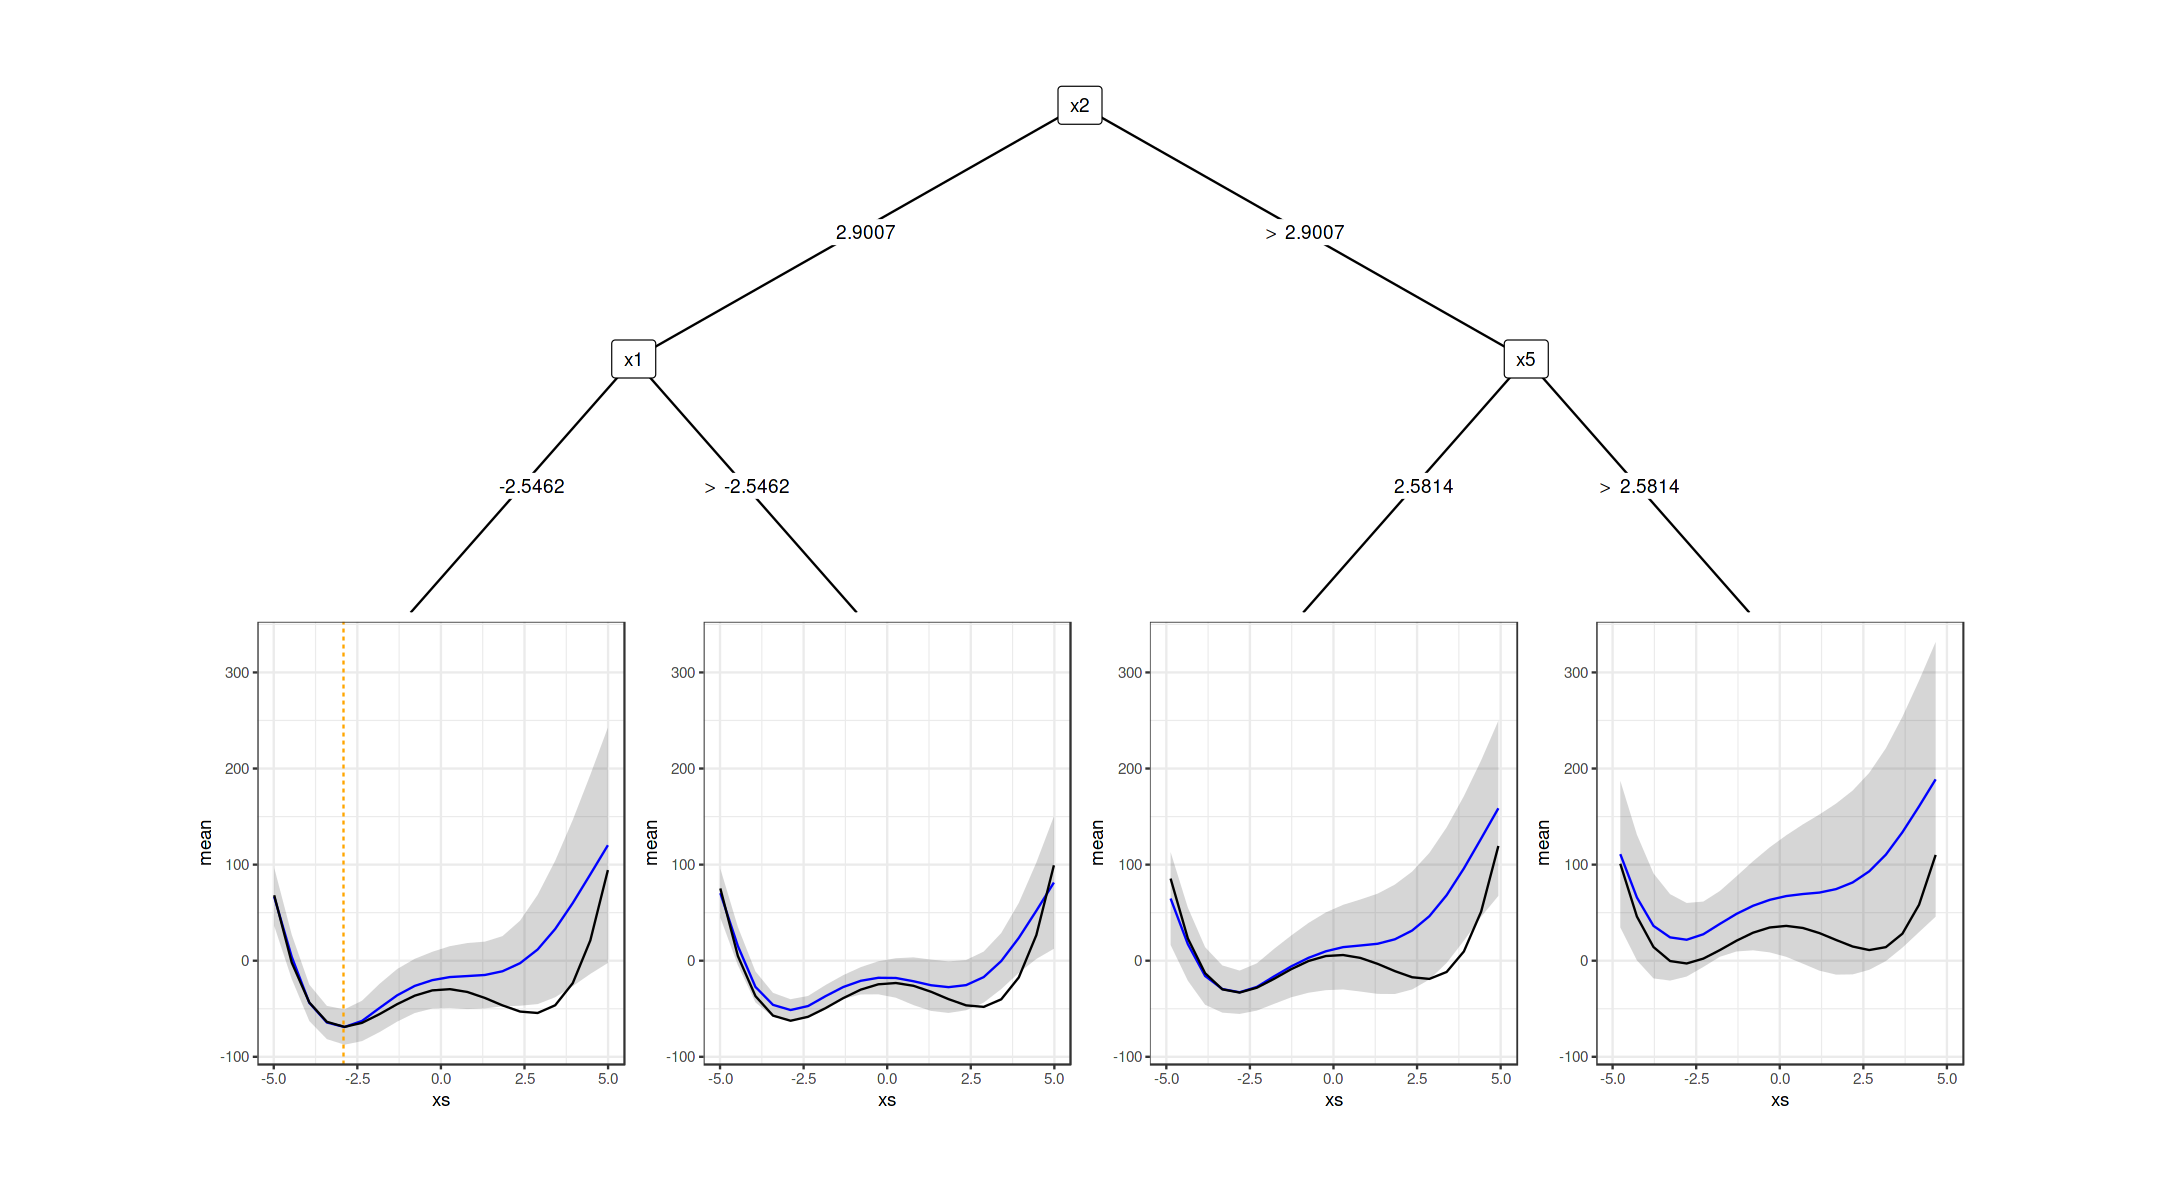

In [65]:
options(repr.plot.width=18, repr.plot.height=10)

p

Warning message:
“Removed 190 row(s) containing missing values (geom_path).”
Warning message:
“Removed 190 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1000 rows containing missing values (geom_vline).”
Warning message:
“Removed 1942 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1942 row(s) containing missing values (geom_path).”
Warning message:
“Removed 2000 rows containing missing values (geom_vline).”


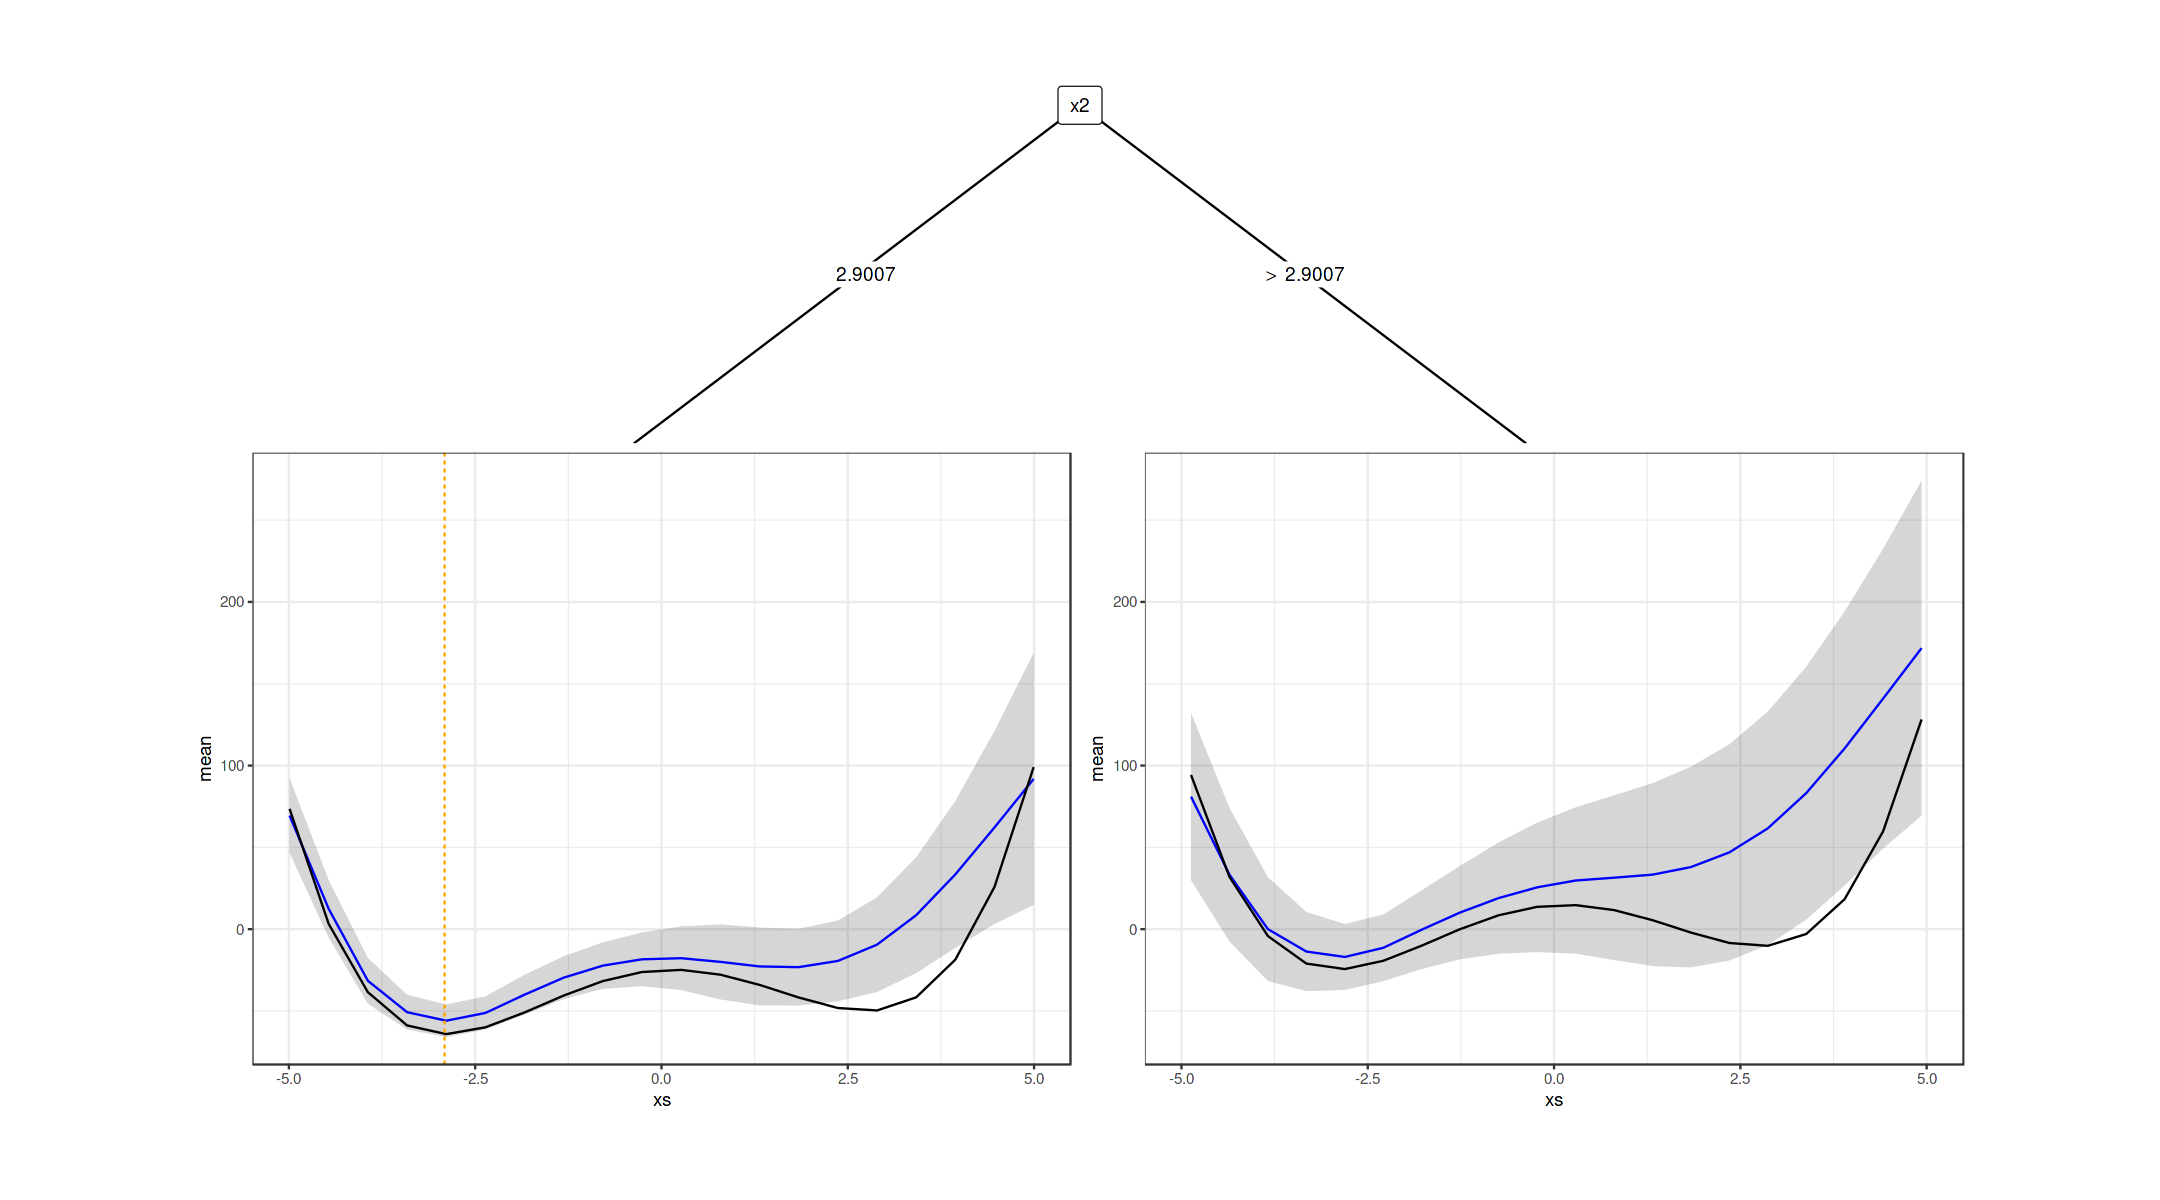

In [68]:
tree = compute_tree(model = model,
            testdata = df, 
            feature = feature, 
            objective = "SS_L1",
            n.split = 1)

p = plot_tree_pdps(tree = tree, 
                df = df, 
                model = model, 
                pdp.feature = feature, 
                obj = obj, 
                method = "pdp_var_gp", 
                alpha = 0.05, 
                best_candidate = best_candidate
                )
p

# MLP

In [2]:
path = "data/runs/mlp/"

folder_mlp = "shuttle"

lambda = 1

In [3]:
# Read the MBO run
run = readRDS(file.path(path, folder_mlp, paste0("1_1_mlrmbo_runs/mlrmbo_run_lambda_", lambda, "_30repls.rds")))[1, ]$result[[1]]
opdf = run$opt.path

In [41]:
model = run$models[[2]]

In [4]:
best_candidate = opdf[which.min(opdf$y), ]

In [33]:
surr_val = readRDS(file.path(path, folder_mlp, "0_objective", "surrogate.rds"))$result[[1]]$model_val_balanced_acc[[1]]
obj = readRDS(file.path(path, folder_mlp, "0_objective", "obj.rds"))$obj
ps = getParamSet(obj)
ps_ids = getParamIds(ps)

In [42]:
df = readRDS(file.path(path, folder_mlp, "2_1_testdata", "testdata_1000.rds"))

In [6]:
# Get the tree
trees = readRDS(file.path(path, folder_mlp, "2_3_effects_and_trees", "eval_SS_L2_20_1000.rds"))

In [57]:
res = trees$result[[1]]$reslist[[1]]$weight_decay

In [58]:
tree = res$trees[[1]][1:2]

In [59]:
tree[[2]]$left.child$children = NULL

In [60]:
plot_tree_pdps(tree, df, model, "weight_decay", obj = obj, depth = 2, method = "pdp_var_gp", grid.size = 20) 

ERROR: Error in initialize(...): Assertion on 'X' failed: Contains only missing values.


In [61]:
    depth = length(tree)
    
    # First, build a tree in partykit
    # Create partysplit objects for all splits that are performed
    splits = lapply(seq_len(depth - 1), function(i) {
      lapply(seq_len(length(tree[[i]])), function(j) {
          node = tree[[i]][[j]]
          partysplit(which(node$split.feature == ps_ids), breaks = round(node$split.value, 4))
        })
    })
    
    d = depth - 1
    
    ids = 2^(d):(2^(d + 1) - 1)

    # Create the leave nodes as partynodes (placeholder)
    nodes = lapply(ids, function(i) {
        partynode(id = i)
    })

    # Now, recursively build the tree
    for (d in seq(depth - 2, 0)) {
        ids = 2^(d):(2^(d + 1) - 1)

        # transfer all into nodes and use the correct children
        nodes = lapply(seq_along(ids), function(i) {
            partynode(i, split = splits[[d + 1]][[i]], kids = 
                nodes[(2 * i - 1):(2 * i)]
            )
        })
    }

    ntest = nrow(df)

    df_orig = df

    if (!is.null(best_candidate))
      df = rbind(df, best_candidate[, names(df)]) 

    # Modify the test data (this is just a dirty workaround)
    df$sd = NA
    df$mean = NA
    df$xs = NA
    df$lower = NA
    df$upper = NA
    df$gt = NA
    df$best = NA
    df$subset_idx = seq_len(nrow(df))

    py = party(node = nodes[[1]], data = df)
    
    # Create a ggparty object
    ggpobj = ggparty(py)
    
    stack = tree[[1]]
    i = 1


ERROR: Error in `[.data.frame`(best_candidate, , names(df)): undefined columns selected


In [72]:
  plotdata = compute_pdp_for_node(node = node, 
    testdata = df_orig,
    model = model, 
    pdp.feature = pdp.feature, 
    grid.size = grid.size,
    objective.gt = obj, 
    method = method, 
    alpha = alpha)

ERROR: Error in initialize(...): Assertion on 'X' failed: Contains only missing values.


In [68]:
while (length(stack) > 0) {

  # check the first element of the stack      
  node = stack[[1]]

  plotdata = compute_pdp_for_node(node = node, 
    testdata = df_orig,
    model = model, 
    pdp.feature = pdp.feature, 
    grid.size = grid.size,
    objective.gt = obj, 
    method = method, 
    alpha = alpha)

  pp = plotdata$pdp_data
  pp.gt = plotdata$pdp_groundtruth_data

  tl = length(ggpobj$data[, paste0("nodedata_", pdp.feature)][[i]])

  if (tl > nrow(pp)) {
    ggpobj$data$nodedata_xs[[i]] = c(pp[ , pdp.feature], rep(NA, tl - nrow(pp)))
    ggpobj$data$nodedata_mean[[i]] = c(pp[ , "mean"], rep(NA, tl - nrow(pp)))
    ggpobj$data$nodedata_lower[[i]] = c(pp[ , "lower"], rep(NA, tl - nrow(pp)))
    ggpobj$data$nodedata_upper[[i]] = c(pp[ , "upper"], rep(NA, tl - nrow(pp)))

    if (!is.null(obj))
        ggpobj$data$nodedata_gt[[i]] = c(pp.gt$mean, rep(NA, tl - nrow(pp)))

    if (!is.null(best_candidate) && (ntest + 1) %in% ggpobj$data$nodedata_subset_idx[[i]]) {
        ggpobj$data$nodedata_best[[i]][1] = best_candidate[, pdp.feature][1]            
    }

  }

  # remove it from the stack
  stack[[1]] = NULL

  # extend the stack
  stack = c(node$children$left.child, node$children$right.child, stack)

  i = i + 1
}


ERROR: Error in initialize(...): Assertion on 'X' failed: Contains only missing values.


In [62]:
    p = ggpobj +
      geom_edge() +
      geom_edge_label() +
      geom_node_splitvar() 


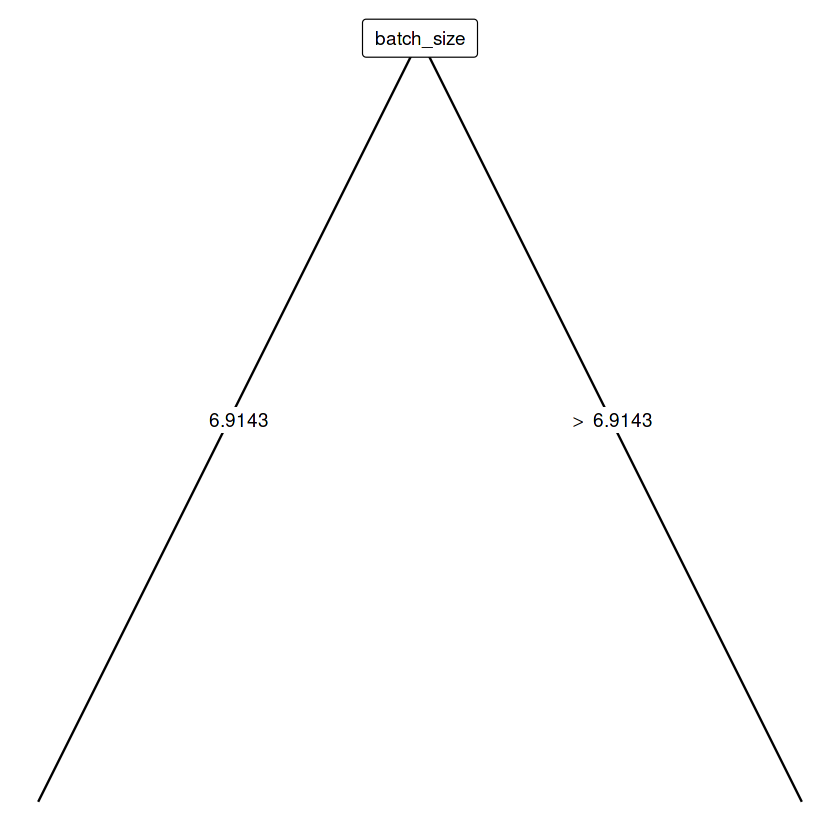

In [63]:
p

In [65]:
p = p + geom_node_plot(gglist = list(
                             geom_ribbon(aes(x = xs, ymin = lower, ymax = upper), alpha = 0.2), 
                             geom_line(aes(x = xs, y = mean), colour = "blue")
                            ))


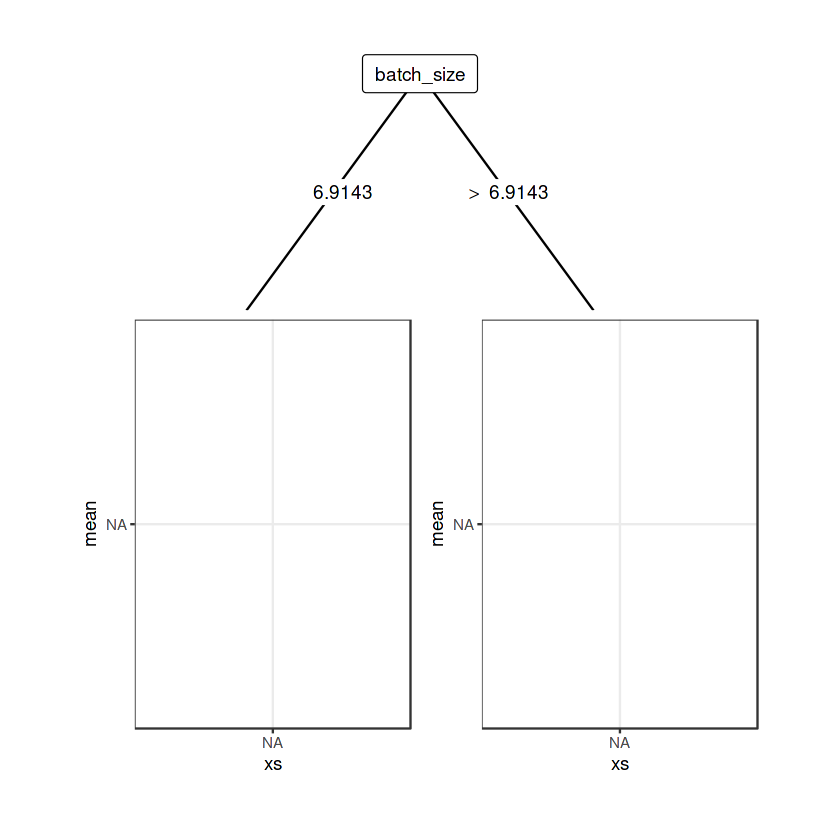

In [66]:
p

In [24]:


    ntest = nrow(df)

    df_orig = df

    if (!is.null(best_candidate))
      df = rbind(df, best_candidate[, names(df)]) 

    # Modify the test data (this is just a dirty workaround)
    df$sd = NA
    df$mean = NA
    df$xs = NA
    df$lower = NA
    df$upper = NA
    df$gt = NA
    df$best = NA
    df$subset_idx = seq_len(nrow(df))

    py = party(node = nodes[[1]], data = df)
    
    # Create a ggparty object
    ggpobj = ggparty(py)
    
    stack = tree[[1]]
    i = 1

    # Now create the data for the pdps 

    while (length(stack) > 0) {

      # check the first element of the stack      
      node = stack[[1]]
      
      plotdata = compute_pdp_for_node(node = node, 
        testdata = df_orig,
        model = model, 
        pdp.feature = pdp.feature, 
        grid.size = grid.size,
        objective.gt = obj, 
        method = method, 
        alpha = alpha)

      pp = plotdata$pdp_data
      pp.gt = plotdata$pdp_groundtruth_data

      tl = length(ggpobj$data[, paste0("nodedata_", pdp.feature)][[i]])

      if (tl > nrow(pp)) {
        ggpobj$data$nodedata_xs[[i]] = c(pp[ , pdp.feature], rep(NA, tl - nrow(pp)))
        ggpobj$data$nodedata_mean[[i]] = c(pp[ , "mean"], rep(NA, tl - nrow(pp)))
        ggpobj$data$nodedata_lower[[i]] = c(pp[ , "lower"], rep(NA, tl - nrow(pp)))
        ggpobj$data$nodedata_upper[[i]] = c(pp[ , "upper"], rep(NA, tl - nrow(pp)))

        if (!is.null(obj))
            ggpobj$data$nodedata_gt[[i]] = c(pp.gt$mean, rep(NA, tl - nrow(pp)))
      
        if (!is.null(best_candidate) && (ntest + 1) %in% ggpobj$data$nodedata_subset_idx[[i]]) {
            ggpobj$data$nodedata_best[[i]][1] = best_candidate[, pdp.feature][1]            
        }

      }

      # remove it from the stack
      stack[[1]] = NULL

      # extend the stack
      stack = c(node$children$left.child, node$children$right.child, stack)

      i = i + 1
    }

    p = ggpobj +
      geom_edge() +
      geom_edge_label() +
      geom_node_splitvar() 

    if (!is.null(best_candidate) && !is.null(obj)) {

    p = p + geom_node_plot(gglist = list(
                                   geom_ribbon(aes(x = xs, ymin = lower, ymax = upper), alpha = 0.2), 
                                   geom_line(aes(x = xs, y = mean), colour = "blue"), 
                                   geom_line(aes(x = xs, y = gt)), 
                                   geom_vline(aes(xintercept = best), colour = "orange", lty = 2)
                                  )
                    )
    } 

    if (is.null(best_candidate) && !is.null(obj) ) {

      p = p + geom_node_plot(gglist = list(
                                     geom_ribbon(aes(x = xs, ymin = lower, ymax = upper), alpha = 0.2), 
                                     geom_line(aes(x = xs, y = mean), colour = "blue"), 
                                     geom_line(aes(x = xs, y = gt))
                                    )
                      )
      } 


    if (!is.null(best_candidate) && is.null(obj) ) {

      p = p + geom_node_plot(gglist = list(
                                     geom_ribbon(aes(x = xs, ymin = lower, ymax = upper), alpha = 0.2), 
                                     geom_line(aes(x = xs, y = mean), colour = "blue"), 
                                      geom_vline(aes(xintercept = best), colour = "orange", lty = 2)
                                    )
                      )
      } 


     if (is.null(best_candidate) && is.null(obj) ) {

      p = p + geom_node_plot(gglist = list(
                                     geom_ribbon(aes(x = xs, ymin = lower, ymax = upper), alpha = 0.2), 
                                     geom_line(aes(x = xs, y = mean), colour = "blue")
                                    )
                      )
      }       


[[1]]
[[1]][[1]]
[[1]][[1]][[1]]
<Node>
  Public:
    child.type: NULL
    children: list
    clone: function (deep = FALSE) 
    computeChildren: function (X, Y) 
    computeSplit: function (X, Y, objective, optimizer, min.split = 10) 
    depth: 1
    id: 0
    id.parent: NULL
    initialize: function (id, depth = NULL, subset.idx, id.parent = NULL, child.type = NULL) 
    objective.value: 0.382005629721877
    split.feature: batch_size
    split.value: 6.91426381212659
    stop.criterion.met: FALSE
    subset.idx: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 ...


[[1]][[2]]
[[1]][[2]]$left.child
<Node>
  Public:
    child.type: <=
    children: list
    clone: function (deep = FALSE) 
    computeChildren: function (X, Y) 
    computeSplit: function (X, Y, objective, optimizer, min.split = 10) 
    depth: 2
    id: 1
    id.parent: 0
    initialize: function (id, depth = NULL, subset.idx, id.parent = NULL, child.type = NULL) 
    objective.value: 0.13227615689655
    spl

In [43]:
feature = "momentum"
df = generateDesign(par.set = ps, n = 1000, fun = lhs::randomLHS)

tree = compute_tree(model = model,
            testdata = df, 
            feature = feature, 
            objective = "SS_L1",
            n.split = 3)

p = plot_tree_pdps(tree = tree, 
                df = df, 
                model = model, 
                pdp.feature = feature, 
                # obj = obj, 
                method = "pdp_var_gp", 
                alpha = 0.05, 
                best_candidate = best_candidate
                )

Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Removed 26 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1000 rows containing missing values (geom_vline).”
Warning message:
“Removed 3724 row(s) containing missing values (geom_path).”
Warning message:
“Removed 4000 rows containing missing values (geom_vline).”


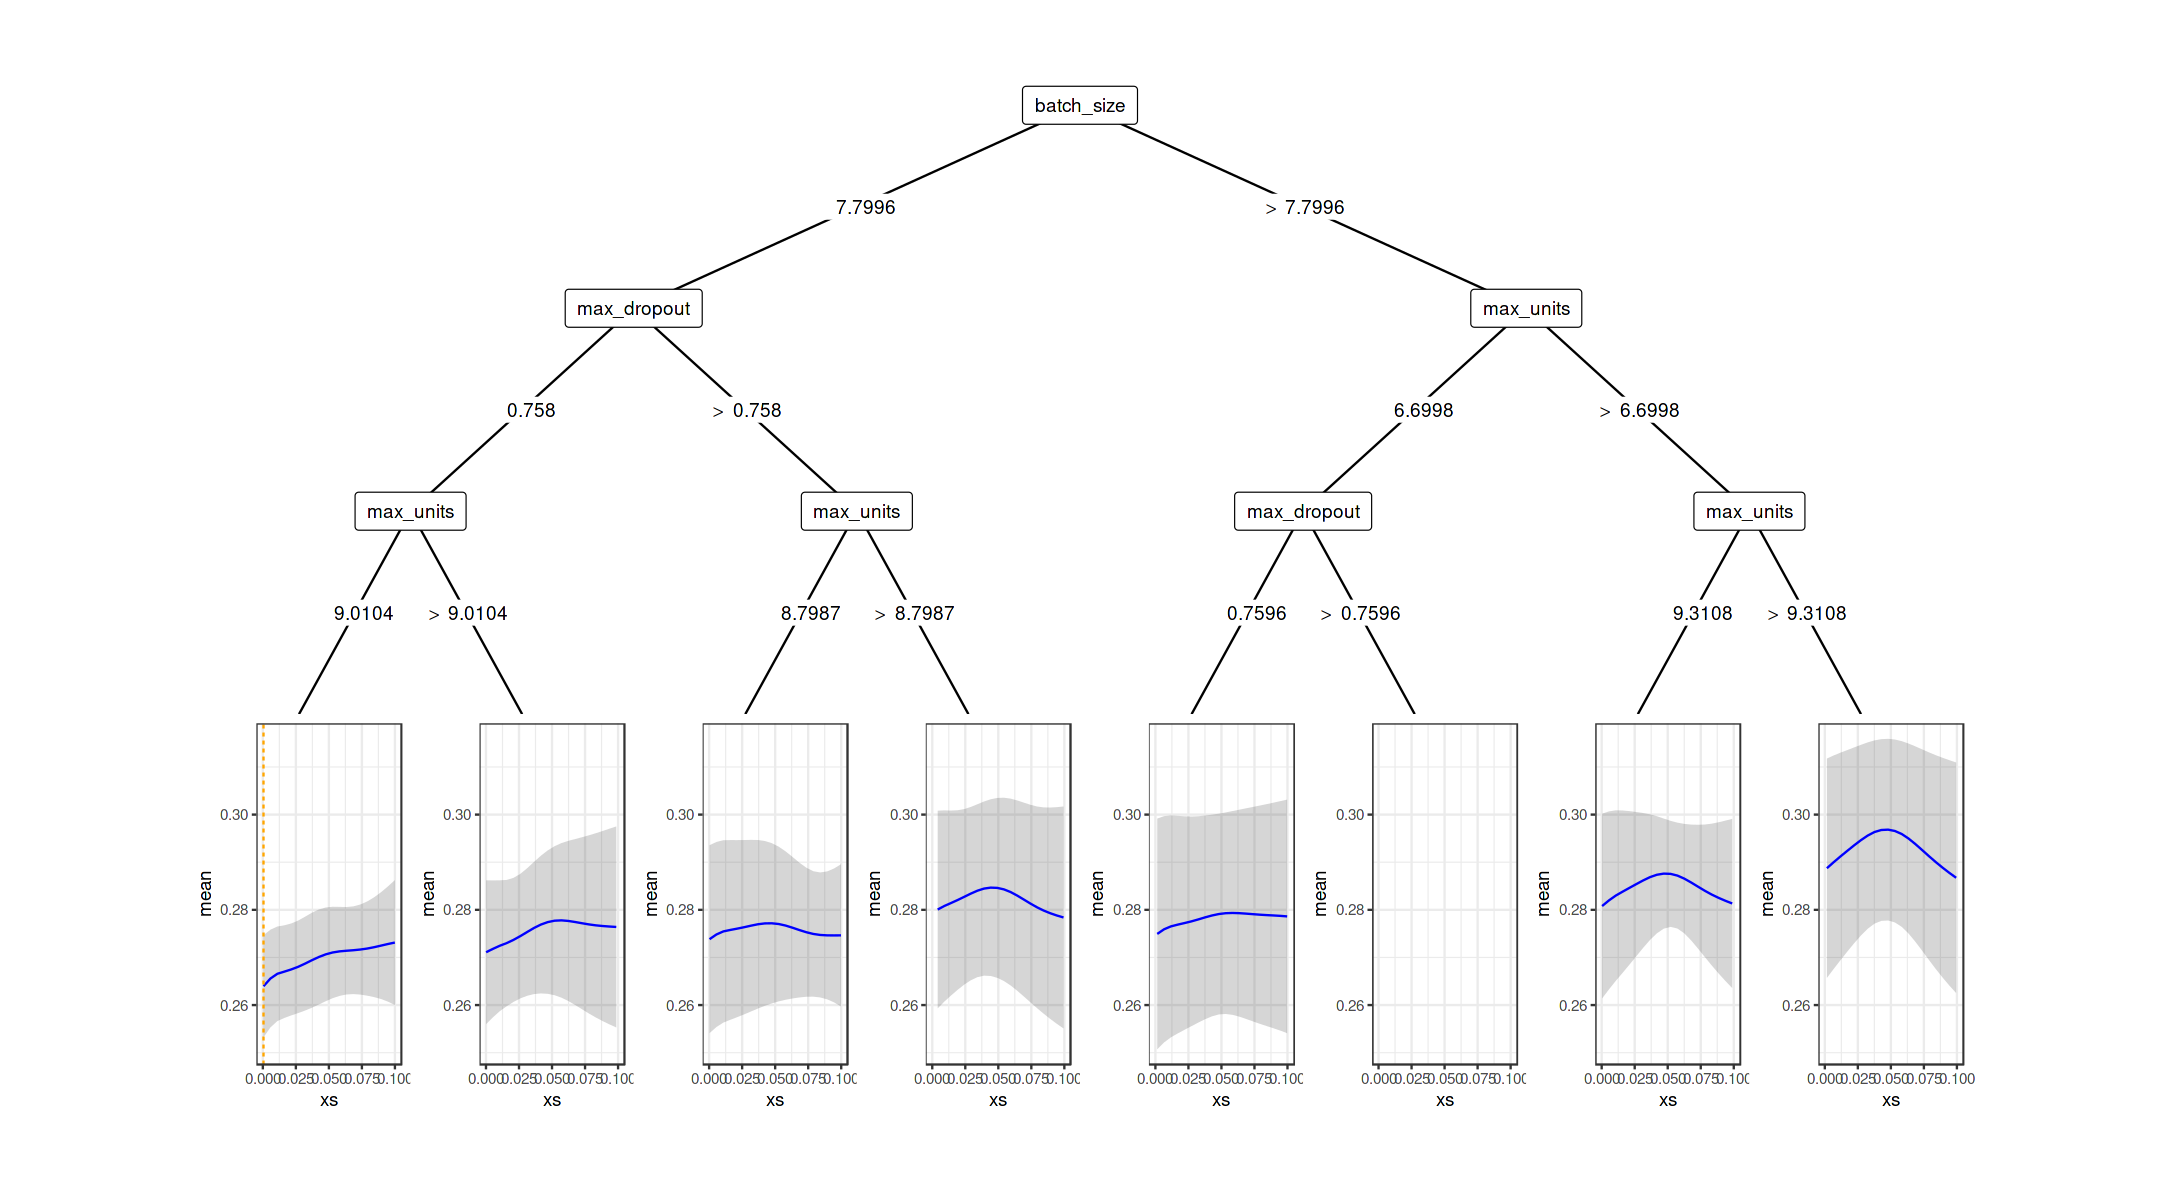

In [42]:
options(repr.plot.width=18, repr.plot.height=10)

p

# xgboost

In [ ]:
## -- MLP 

path = "data/runs/xgboost/"

dataset = "phoneme"
data = readRDS(file.path(path, dataset, "mlrmbo_30_repls.rds"))

lambda = 1
iteration = 2

idx = which(data$lambda == lambda)[iteration]

run = data[idx, ]$result[[1]]
model = run$models[[length(run$models)]]
best_candidate = run$opt.path[which.min(run$opt.path$y), ]

# store this in a better format
ps =  readRDS(file.path(path, "ps.rds"))
ps_ids = getParamIds(ps, repeated = TRUE, with.nr = TRUE)


In [ ]:
feature = "max_depth"
df = generateDesign(par.set = ps, n = 1000, fun = lhs::randomLHS)

In [ ]:
tree = compute_tree(model = model,
            testdata = df, 
            feature = feature, 
            objective = "SS_L1",
            n.split = 3)

plot_tree_pdps(tree = tree, 
                df = df, 
                model = model, 
                pdp.feature = feature, 
                # obj = obj, 
                method = "pdp_var_gp", 
                alpha = 0.05, 
                best_candidate = best_candidate
                )

In [ ]:
compute_tree = function(model, testdata, feature, objective, n.split) {

  if (objective == "SS_L1") {
    mymodel = makeS3Obj("mymodel", fun = function() return(model))
    predict.mymodel = function(object, newdata) {
      pred = predict(object$fun(), newdata = newdata)
      pp = getPredictionSE(pred)
      return(pp)
    }
    predictor = Predictor$new(model = mymodel, data = testdata[, model$features], predict.function = predict.mymodel)
    effect = FeatureEffect$new(predictor = predictor, feature = feature, method = "ice")

    # define objective
    split.objective = function(y, x, requires.x = FALSE, ...) {
      require(Rfast)
      ypred = Rfast::colMedians(as.matrix(y))
      sum(t(abs(t(y) - ypred)))
    } 

    input.data = compute_data_for_ice_splitting(effect)
  } else {
    stop(paste("Objective", objective, "is not supported."))
  } 

  # Initialize the parent node of the tree
  parent = Node$new(id = 0, depth = 0, X = input.data$X, Y = input.data$Y, subset.idx = seq_len(nrow(input.data$X)))
  
  # Perform splitting for the parent
  tree = list(list(parent))

  for (depth in seq_len(n.split)) {

    leaves = tree[[depth]]

    tree[[depth + 1]] = list()

    for (node.idx in seq_along(leaves)) {

      node.to.split = leaves[[node.idx]]

      if (!is.null(node.to.split)) {
        node.to.split$computeSplit(split.objective, find_best_binary_split)
        node.to.split$computeChildren()

        tree[[depth + 1]] = c(tree[[depth + 1]], node.to.split$children)        
      } else {
        tree[[depth + 1]] = c(tree[[depth + 1]], list(NULL, NULL))                
      }
    }
  }
  return(list(tree = tree, effect = effect))
}
